# Continental-scale Intertidal Digital Elevation Model

## Load modules and set up analysis

In [ ]:
# Import libraries
import sys
import os
import glob
import fiona
import itertools
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import statsmodels.formula.api as sm
from shapely.geometry import Point, LineString, MultiLineString, mapping
from fiona.crs import from_epsg
from osgeo import gdal
from scipy.interpolate import griddata
from skimage import measure
from matplotlib import pyplot as plt

# Import DEA Notebooks scripts
sys.path.append(os.path.abspath('/g/data/r78/rt1527/dea-notebooks/algorithms'))
from DEADataHandling import array_to_geotiff


"""
TODO: Investigate scipy.interpolate.RectBivariateSpline, scipy.interpolate.interp2d,
spipy.interpolate.RegularGridInterpolator, sklearn.gaussian_process.GaussianProcess
"""

# Set ITEM polygon for analysis
polygon_ID = 33

# Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
# plotting_subset = np.index_exp[:, :]
plotting_subset = np.index_exp[1750: 1950, 930:1130]

## ITEM class boundary investigation

ITEM classes: [-9999, -2375, -1928, -1404, -796, -268, 297, 881, 1403, 2104]
Elev classes: [-2749, -2190, -1630, -1071, -511, 47, 607, 1167, 1726, 2286]


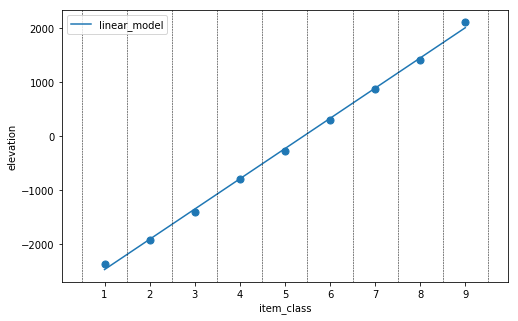

In [6]:
# Import ITEM elevation classes
elevations = np.loadtxt("/g/data2/v10/ITEM/offset_products/elevation.txt", delimiter = ",", dtype = "str")
elev_dict = {int(key):[int(val) for val in value.split(" ")] for (key, value) in elevations}
item_classes = [-9999] + elev_dict[polygon_ID]
print("ITEM classes: {}".format(item_classes))

# Create dataframe
df = pd.DataFrame({"item_class": range(1,10),
                   "elevation": item_classes[1:]})

# Compute linear model
result = sm.ols(formula="elevation~item_class", data=df).fit().params

# Add values to column
df['linear_model'] = df.apply(lambda row: result.item_class * row.item_class + result.Intercept, axis=1)

# Plot output
fig, ax = plt.subplots(figsize=(8,5))
df.plot(kind = "scatter", x = "item_class", y = "elevation", s = 50, ax = ax, xticks=df['item_class'])
df.plot(kind = "line", x = "item_class", y = "linear_model", ax = ax)
for xc in np.arange(0.5, 10.5, 1.0):
    plt.axvline(x=xc, color='k', linestyle='--', lw = 0.5)
    
elev_classes = (result.item_class * np.arange(0.5, 10.5) + result.Intercept).astype(int).tolist()
print("Elev classes: {}".format(elev_classes))

## Import and prepare ITEM OFFSET

ITEM classes: [-9999, -2375, -1928, -1404, -796, -268, 297, 881, 1403, 2104]


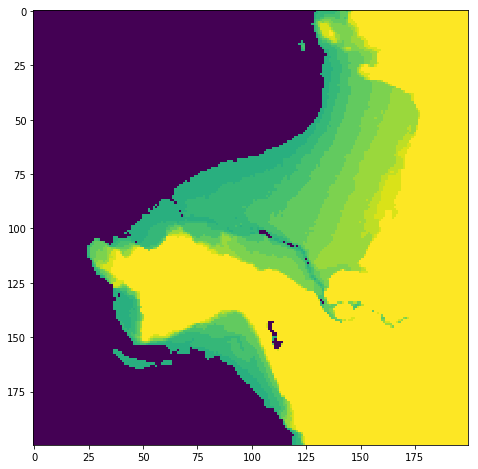

In [8]:
# Import raster and extract shape, projection info and geotransform data
filename = glob.glob("/g/data2/v10/ITEM/offset_products/ITEM_OFFSET_{}_*.tif".format(polygon_ID))[0]
src_ds = gdal.Open(filename)
srcarray = src_ds.GetRasterBand(1).ReadAsArray() 
yrows, xcols = srcarray.shape
prj = src_ds.GetProjection()
geotrans = src_ds.GetGeoTransform()
upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans

# Copy original data so array can be modified 
item_array = np.copy(srcarray)

# Set nodata to NaN, and force 0 values to a low negative  (-9999) to allow correct 
# contour extraction (i.e. make "0" data sit beneath the lowest ITEM tidal stage)
item_array[item_array == -6666] = np.nan
item_array[item_array == 0] = -9999 

# Import elevation values from file
elevations = np.loadtxt("/g/data2/v10/ITEM/offset_products/elevation.txt", delimiter = ",", dtype = "str")
elev_dict = {int(key):[int(val) for val in value.split(" ")] for (key, value) in elevations}
item_classes = [-9999] + elev_dict[polygon_ID]
print("ITEM classes: {}".format(item_classes))

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(item_array[plotting_subset])  
plt.show()

## Extract contours

In [9]:
# Set up output list and items to iterate over; subtract 1m from highest class to allow
# highest contour to calculate (otherwise, this height is read as being in NaN area)
contour_classes = item_classes[0:9] + [item_classes[9] - 1.0]
# elev_classes = [item_classes[np.min((9, n + 1))] for n in range(0,10)]

# Output dict
from collections import OrderedDict
contour_dict = OrderedDict()

for n, contour_class in enumerate(contour_classes):
    
    # Extract contours from array
    contours = measure.find_contours(item_array, contour_class)      
    elevation_value = elev_classes[n] # item_classes[np.min((9, n + 1))]
    print("Extracting contour {}".format(elevation_value))

    # Iterate through each contour feature, remove NAs and fix coordinates
    contour_list = list()
    for contour in contours:
        
        # Convert index coordinates to spatial coordinates in-place
        contour[:,0] = contour[:,0] * float(y_size) + upleft_y + (float(y_size) / 2)
        contour[:,1] = contour[:,1] * float(x_size) + upleft_x + (float(x_size) / 2)        
        contour = np.insert(contour, 2, elevation_value, axis = 1)

        # Remove contour points with NAs
        contour = contour[~np.isnan(contour).any(axis=1)] 
        contour_list.append(contour)
        
    # Add list of contour arrays to dict 
    contour_dict[elevation_value] = contour_list

    
# Export points to shapefile
schema = {'geometry':  'MultiLineString', 
          'properties': { 'elevation': 'int' } }      

with fiona.open("output_data/ITEM_DEM_{}_lines.shp".format(polygon_ID), "w", 
                crs = from_epsg(3577),
                driver = "ESRI Shapefile", 
                schema = schema) as output:
    
    for elevation_value, contour_list in contour_dict.items():
        
        # For line shapefile export, keep only arrays with at least two points (to make lines)
        contour_list = [x for x in contour_list if len(x) > 1]
        
        # Create multiline string by first flipping coordinates then creating list of linestrings
        contour_linestrings = [LineString([(x, y) for (y, x, z) in contour_array]) 
                               for contour_array in contour_list]
        contour_multilinestring = MultiLineString(contour_linestrings)

        # Write output shapefile to file with elevation field        
        output.write({'properties': { 'elevation': elevation_value },
                      'geometry': mapping(contour_multilinestring) })
        
# Chain and concatenate all arrays nested within array lists (i.e. individual collections of same 
# elevation contours) and dictionary entries (i.e. collections of all same-elevation contours)
alldata = np.concatenate(list(itertools.chain.from_iterable(contour_dict.values())))
points = alldata[:,0:2]
values = alldata[:,2]


Extracting contour -2749
Extracting contour -2190
Extracting contour -1630
Extracting contour -1071
Extracting contour -511
Extracting contour 47
Extracting contour 607
Extracting contour 1167
Extracting contour 1726
Extracting contour 2286


## Interpolate points
Exports a DEM by interpolating previously extracted contours. This uses the linear method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using Qhull before performing linear barycentric interpolation on each triangle.

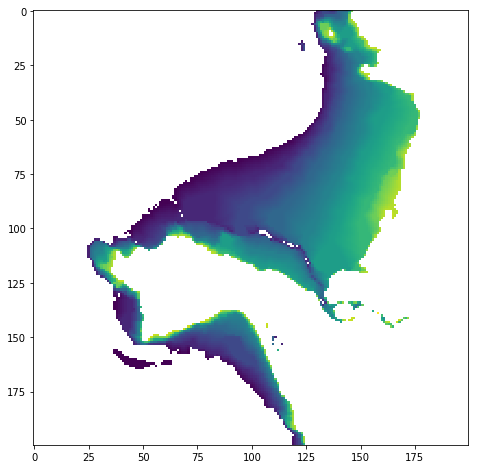

In [10]:
# Extract bounds of ITEM layer
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid (from, to, by in metres)
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
interpolated_array = griddata(points, values, (grid_y, grid_x), method = "linear")

# Mask out NaNs, zero values and max tidal stage from original ITEM offset layer
gooddata_mask = ((srcarray != -6666) & (srcarray != 0) & (srcarray != item_classes[9]))
interpolated_array[~gooddata_mask] = np.nan

# Plot
plt.figure(figsize = (8, 8))
plt.imshow(interpolated_array[plotting_subset])
plt.show()

# Export to tif
array_to_geotiff(fname = "output_data/ITEM_DEM_{}_new.tif".format(polygon_ID), 
                 data = interpolated_array, 
                 geo_transform = geotrans, 
                 projection = prj, 
                 nodata_val = np.nan)


## Validation

Text(0.5,1,'val_elevation ~ mod_elevation, R-squared = 0.697')

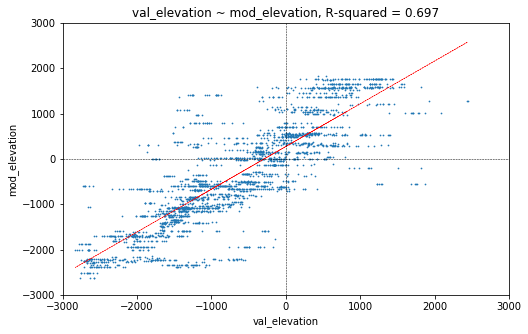

In [11]:
# Open validation point shapefile and use to extract data from underlying array
with fiona.open('raw_data/EastPointonlyRTK_albers.shp') as points:

    point_output = list()

    for n, point in enumerate(points):

        # Extract data from shapefile points
        x, y = point["geometry"]["coordinates"]
        val_elev = point["properties"]["field_4"] * 1000.0

        # Convert geographic coordinates into index coordinates
        x_ind = int((x - upleft_x) / x_size) # x pixel
        y_ind = int((y - upleft_y) / y_size) # y pixel 

        # Extract modelled elevation from DEM array
        mod_elev = interpolated_array[y_ind, x_ind]

        # Append to list
        point_output.append([x, y, val_elev, mod_elev])

# Combine into dataframe    
colnames = ["x", "y", "val_elevation", "mod_elevation"]
modval_elev = pd.DataFrame(point_output, columns = colnames).dropna() 
modval_elev = modval_elev[modval_elev['val_elevation'] < 2500]

# Compute linear model
lm_elev = sm.ols(formula = "val_elevation~mod_elevation", data = modval_elev).fit()
m, b = np.polyfit(modval_elev["val_elevation"], modval_elev["mod_elevation"], 1)

# Plot output x-y scatter plot
fig, ax = plt.subplots(figsize = (8, 5))
modval_elev.plot(x = "val_elevation", 
                 y = "mod_elevation", 
                 kind = "scatter", 
                 s = 0.5, ax = ax)
ax.plot(modval_elev["val_elevation"], m * modval_elev["val_elevation"] + b, 
        color = 'red', linestyle = '--', lw = 0.5)
plt.axvline(x = 0, color = 'k', linestyle = '--', lw = 0.5)
plt.axhline(y = 0, color = 'k', linestyle = '--', lw = 0.5)
ax.set_ylim(-3000, 3000)
ax.set_xlim(-3000, 3000)
plt.title("val_elevation ~ mod_elevation, R-squared = {}".format(np.round(lm_elev.rsquared, 3)))
